This pipeline labels gene expression and accessibility changes as up/down/flat over time and compares them to identify agreement types (e.g., both up, one up/one down). It summarizes and classifies each gene's temporal agreement pattern, helping reveal coordinated or conflicting regulatory responses.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

In [2]:
# this cell runs this pipeline and saves the data for all chr.
# for individual analysis, see each cells below 
# note = individual cell may not be updated (refer back to this cell for updated code)

# Define a function to summarize peaks per gene
# Function to label direction per timepoint
def direction_vector(values, threshold):
    dirs = []
    for v in values:
        if np.isnan(v):
            dirs.append('na')
        elif v > threshold:
            dirs.append('up')
        elif v < -threshold:
            dirs.append('down')
        else:
            dirs.append('flat')
    return dirs

# Format readable versions
def combine_pairs_and_labels(pairs, labels):
    return [f"{a}/{b} , {label}" for (a, b), label in zip(pairs, labels)]

def agreement_pattern(seq1, seq2, pair_to_category):
    agreement = []
    direction_pairs = []
    for a, b in zip(seq1, seq2):
        if 'na' in (a, b):
            agreement.append('na')
            direction_pairs.append(['na', 'na'])
        else:
            agreement.append(pair_to_category.get(f'{a}/{b}', 'na'))
            direction_pairs.append([a, b])
    return agreement, direction_pairs

# Summarize agreement types
def agreement_summary_new(agreement_seq):
    return pd.Series({
        'increase': agreement_seq.count('increase'),
        'decrease': agreement_seq.count('decrease'),
        'neutral': agreement_seq.count('neutral'),
        'expr_only_up': agreement_seq.count('expr_only_up'),
        'expr_only_down': agreement_seq.count('expr_only_down'),
        'acc_only_up': agreement_seq.count('acc_only_up'),
        'acc_only_down': agreement_seq.count('acc_only_down'),
        'expr_up_acc_down': agreement_seq.count('expr_up_acc_down'),
        'expr_down_acc_up': agreement_seq.count('expr_down_acc_up')
    })

# Classify gene-level agreement pattern
def classify_agreement(row):
    counts = pd.to_numeric(row[
        ['increase', 'decrease', 'neutral',
         'expr_only_up', 'expr_only_down',
         'acc_only_up', 'acc_only_down',
         'expr_up_acc_down', 'expr_down_acc_up']
    ], errors='coerce').fillna(0).astype(int)

    max_type = counts.idxmax()
    max_count = counts.max()

    if max_type == 'increase' and max_count == 3:
        return 'expr_acc_up'
    elif max_type == 'decrease' and max_count == 3:
        return 'expr_acc_down'
    elif (counts['expr_up_acc_down'] + counts['expr_down_acc_up']) >= 2:
        return 'conflict'
    elif 'expr_only' in max_type:
        return 'expression_only'
    elif 'acc_only' in max_type:
        return 'accessibility_only'
    elif max_type == 'neutral':
        return 'stable'
    return 'mixed'
        
def extract_expr_acc_temporal_trends(file_path):
    for chr_folder_name in os.listdir(file_path):
        chr_path = os.path.join(file_path, chr_folder_name)
        if not os.path.isdir(chr_path) or not chr_folder_name.startswith('chr'):
            continue
        data = pd.read_csv(f"{file_path}{chr_folder_name}/{chr_folder_name}_expr_acc_features.csv")
        # Required columns
        expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
        acc_tss_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
        required_cols = expr_cols + acc_tss_cols 
        
        # Drop rows with NaNs in required columns
        data = data.dropna(subset=required_cols).copy()
        
        # Separate delta magnitudes
        expr_deltas = np.concatenate([abs(data[col].values) for col in expr_cols])
        acc_deltas = np.concatenate([abs(data[col].values) for col in acc_tss_cols])
        
        # Compute thresholds independently
        expr_thres = np.percentile(expr_deltas[~np.isnan(expr_deltas)], 5)
        acc_thres = np.percentile(acc_deltas[~np.isnan(acc_deltas)], 5)

        
        # Compute direction vectors
        data['expr_dir'] = data[expr_cols].apply(lambda row: direction_vector(row.values, expr_thres), axis=1)
        data['acc_tss_dir'] = data[acc_tss_cols].apply(lambda row: direction_vector(row.values, acc_thres), axis=1)
    
        # Agreement mapping
        pair_to_category = {
            'up/up': 'increase',
            'down/down': 'decrease',
            'flat/flat': 'neutral',
            'up/down': 'expr_up_acc_down',
            'down/up': 'expr_down_acc_up',
            'up/flat': 'expr_only_up',
            'down/flat': 'expr_only_down',
            'flat/up': 'acc_only_up',
            'flat/down': 'acc_only_down'
        }
        
        
        
        # Apply agreement encoding
        results = data.apply(lambda row: agreement_pattern(row['expr_dir'], row['acc_tss_dir'], pair_to_category), axis=1)
        data[['expr_acc_tss_agreement', 'expr_acc_direction_pairs']] = pd.DataFrame(results.tolist(), index=data.index)
        
        
        
        data['expr_acc_agreement_verbose'] = data.apply(
            lambda row: combine_pairs_and_labels(row['expr_acc_direction_pairs'], row['expr_acc_tss_agreement']),
            axis=1
        )
        data['expr_acc_direction_pairs_str'] = data['expr_acc_direction_pairs'].apply(
            lambda pairs: [f"{a}/{b}" for a, b in pairs]
        )
    
    
    
        data = pd.concat([data, data['expr_acc_tss_agreement'].apply(agreement_summary_new)], axis=1)
    
        data['agreement_class'] = data.apply(classify_agreement, axis=1)
    
        # Save updated CSV
        data.to_csv(f'{file_path}{chr_folder_name}/{chr_folder_name}_temporal_trend_categories.csv', index=False)

        print(f"{chr_folder_name} data saved")




file_path = 'data/green_monkey/all_structure_files/'
extract_expr_acc_temporal_trends(file_path)

chr23 data saved
chr12 data saved
chr15 data saved
chr14 data saved
chr13 data saved
chr25 data saved
chr22 data saved
chr4 data saved
chr3 data saved
chr2 data saved
chr5 data saved
chr18 data saved
chr27 data saved
chr20 data saved
chr29 data saved
chr16 data saved
chr10 data saved
chr28 data saved
chr21 data saved
chr19 data saved
chr26 data saved
chr7 data saved
chr6 data saved
chr1 data saved


In [4]:
# Load data
data = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_features.csv")

data.head()

,gene_name,expr_delta_12h,expr_delta_18h,expr_delta_24h,acc_delta_12h_tss,acc_delta_18h_tss,acc_delta_24h_tss
0,SCGB1C1,NaN,NaN,NaN,6.35975,2.42210,NaN
1,ODF3,NaN,NaN,NaN,-0.38124,1.51588,-0.92500
2,BET1L,-0.315039,-0.368512,-0.155558,-12.69878,2.12003,8.26010
3,RIC8A,-0.295795,-0.221668,-0.362167,-14.72109,1.21380,-22.87729
4,SIRT3,0.552196,-0.984313,0.300940,0.86934,-0.35920,-1.09724


In [5]:
# Required columns
expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
acc_tss_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
required_cols = expr_cols + acc_tss_cols 

# Drop rows with NaNs in required columns
data = data.dropna(subset=required_cols).copy()

# Separate delta magnitudes
expr_deltas = np.concatenate([abs(data[col].values) for col in expr_cols])
acc_deltas = np.concatenate([abs(data[col].values) for col in acc_tss_cols])

# Compute thresholds independently
expr_thres = np.percentile(expr_deltas[~np.isnan(expr_deltas)], 5)
acc_thres = np.percentile(acc_deltas[~np.isnan(acc_deltas)], 5)


# Function to label direction per timepoint
def direction_vector(values, threshold):
    dirs = []
    for v in values:
        if np.isnan(v):
            dirs.append('na')
        elif v > threshold:
            dirs.append('up')
        elif v < -threshold:
            dirs.append('down')
        else:
            dirs.append('flat')
    return dirs

# Compute direction vectors
data['expr_dir'] = data[expr_cols].apply(lambda row: direction_vector(row.values, expr_thres), axis=1)
data['acc_tss_dir'] = data[acc_tss_cols].apply(lambda row: direction_vector(row.values, acc_thres), axis=1)



In [6]:
# Agreement mapping
pair_to_category = {
    'up/up': 'increase',
    'down/down': 'decrease',
    'flat/flat': 'neutral',
    'up/down': 'expr_up_acc_down',
    'down/up': 'expr_down_acc_up',
    'up/flat': 'expr_only_up',
    'down/flat': 'expr_only_down',
    'flat/up': 'acc_only_up',
    'flat/down': 'acc_only_down'
}

def agreement_pattern(seq1, seq2):
    agreement = []
    direction_pairs = []
    for a, b in zip(seq1, seq2):
        if 'na' in (a, b):
            agreement.append('na')
            direction_pairs.append(['na', 'na'])
        else:
            agreement.append(pair_to_category.get(f'{a}/{b}', 'na'))
            direction_pairs.append([a, b])
    return agreement, direction_pairs

# Apply agreement encoding
results = data.apply(lambda row: agreement_pattern(row['expr_dir'], row['acc_tss_dir']), axis=1)
data[['expr_acc_tss_agreement', 'expr_acc_direction_pairs']] = pd.DataFrame(results.tolist(), index=data.index)

# Format readable versions
def combine_pairs_and_labels(pairs, labels):
    return [f"{a}/{b} , {label}" for (a, b), label in zip(pairs, labels)]

data['expr_acc_agreement_verbose'] = data.apply(
    lambda row: combine_pairs_and_labels(row['expr_acc_direction_pairs'], row['expr_acc_tss_agreement']),
    axis=1
)
data['expr_acc_direction_pairs_str'] = data['expr_acc_direction_pairs'].apply(
    lambda pairs: [f"{a}/{b}" for a, b in pairs]
)

data[['gene_name', 'expr_dir', 'acc_tss_dir', 'expr_acc_direction_pairs', 'expr_acc_tss_agreement', 'expr_acc_agreement_verbose']].head()

,gene_name,expr_dir,acc_tss_dir,expr_acc_direction_pairs,expr_acc_tss_agreement,expr_acc_agreement_verbose
2,BET1L,"[down, down, down]","[down, up, up]","[[down, down], [down, up], [down, up]]","[decrease, expr_down_acc_up, expr_down_acc_up]","[down/down , decrease, down/up , expr_down_acc..."
3,RIC8A,"[down, down, down]","[down, up, down]","[[down, down], [down, up], [down, down]]","[decrease, expr_down_acc_up, decrease]","[down/down , decrease, down/up , expr_down_acc..."
4,SIRT3,"[up, down, up]","[up, down, down]","[[up, up], [down, down], [up, down]]","[increase, decrease, expr_up_acc_down]","[up/up , increase, down/down , decrease, up/do..."
5,PSMD13,"[down, down, down]","[up, up, up]","[[down, up], [down, up], [down, up]]","[expr_down_acc_up, expr_down_acc_up, expr_down...","[down/up , expr_down_acc_up, down/up , expr_do..."
6,NLRP6,"[flat, flat, up]","[up, up, down]","[[flat, up], [flat, up], [up, down]]","[acc_only_up, acc_only_up, expr_up_acc_down]","[flat/up , acc_only_up, flat/up , acc_only_up,..."


In [7]:

# Summarize agreement types
def agreement_summary_new(agreement_seq):
    return pd.Series({
        'increase': agreement_seq.count('increase'),
        'decrease': agreement_seq.count('decrease'),
        'neutral': agreement_seq.count('neutral'),
        'expr_only_up': agreement_seq.count('expr_only_up'),
        'expr_only_down': agreement_seq.count('expr_only_down'),
        'acc_only_up': agreement_seq.count('acc_only_up'),
        'acc_only_down': agreement_seq.count('acc_only_down'),
        'expr_up_acc_down': agreement_seq.count('expr_up_acc_down'),
        'expr_down_acc_up': agreement_seq.count('expr_down_acc_up')
    })

data = pd.concat([data, data['expr_acc_tss_agreement'].apply(agreement_summary_new)], axis=1)




In [8]:
# Flatten the list of agreement types across all genes
all_agreement_labels = sum(data['expr_acc_tss_agreement'].tolist(), [])

# Get value counts as a DataFrame
value_counts_df = pd.Series(all_agreement_labels).value_counts().reset_index()
value_counts_df.columns = ['agreement_type', 'count']

# View result
print(value_counts_df)

     agreement_type  count
0          decrease    606
1  expr_up_acc_down    581
2          increase    540
3  expr_down_acc_up    444
4      expr_only_up     58
5       acc_only_up     57
6     acc_only_down     57
7    expr_only_down     56
8           neutral      7


In [9]:
# Classify gene-level agreement pattern
def classify_agreement(row):
    counts = pd.to_numeric(row[
        ['increase', 'decrease', 'neutral',
         'expr_only_up', 'expr_only_down',
         'acc_only_up', 'acc_only_down',
         'expr_up_acc_down', 'expr_down_acc_up']
    ], errors='coerce').fillna(0).astype(int)

    max_type = counts.idxmax()
    max_count = counts.max()

    if max_type == 'increase' and max_count == 3:
        return 'expr_acc_up'
    elif max_type == 'decrease' and max_count == 3:
        return 'expr_acc_down'
    elif (counts['expr_up_acc_down'] + counts['expr_down_acc_up']) >= 2:
        return 'conflict'
    elif 'expr_only' in max_type:
        return 'expression_only'
    elif 'acc_only' in max_type:
        return 'accessibility_only'
    elif max_type == 'neutral':
        return 'stable'
    return 'mixed'

data['agreement_class'] = data.apply(classify_agreement, axis=1)

data['agreement_class'].value_counts()

agreement_class
mixed                 367
conflict              309
expr_acc_down          58
expr_acc_up            33
accessibility_only     25
expression_only         8
stable                  2
Name: count, dtype: int64

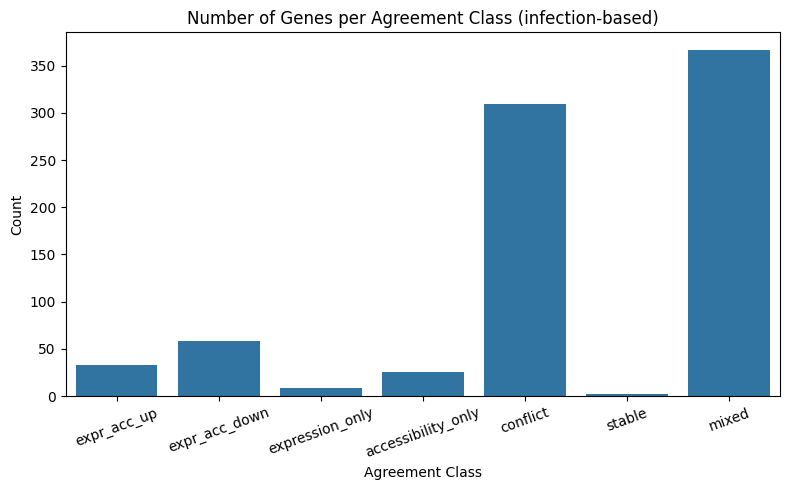

In [10]:
# Plot agreement class counts
plt.figure(figsize=(8, 5))
sns.countplot(
    x='agreement_class',
    data=data,
    order=[
        'expr_acc_up', 'expr_acc_down',
        'expression_only', 'accessibility_only',
        'conflict', 'stable', 'mixed'
    ]
)
plt.title("Number of Genes per Agreement Class (infection-based)")
plt.ylabel("Count")
plt.xlabel("Agreement Class")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()



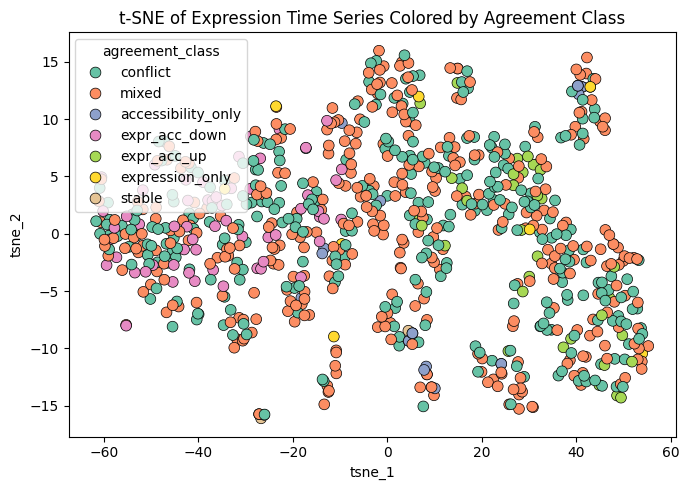

In [11]:
# Create feature matrix from expression time series
X = data[['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']].fillna(0).values

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Store raw t-SNE coordinates
data['tsne_1'] = X_embedded[:, 0]
data['tsne_2'] = X_embedded[:, 1]

# # Add jitter to reduce overplotting
# data['tsne_1_jitter'] = data['tsne_1'] + np.random.normal(0, 30.0, size=data.shape[0])
# data['tsne_2_jitter'] = data['tsne_2'] + np.random.normal(0, 30.0, size=data.shape[0])

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=data,
    x='tsne_1',
    y='tsne_2',
    hue='agreement_class',
    palette='Set2',
    s=60,
    edgecolor='black',
    linewidth=0.5
)
plt.title("t-SNE of Expression Time Series Colored by Agreement Class")
plt.tight_layout()
plt.show()


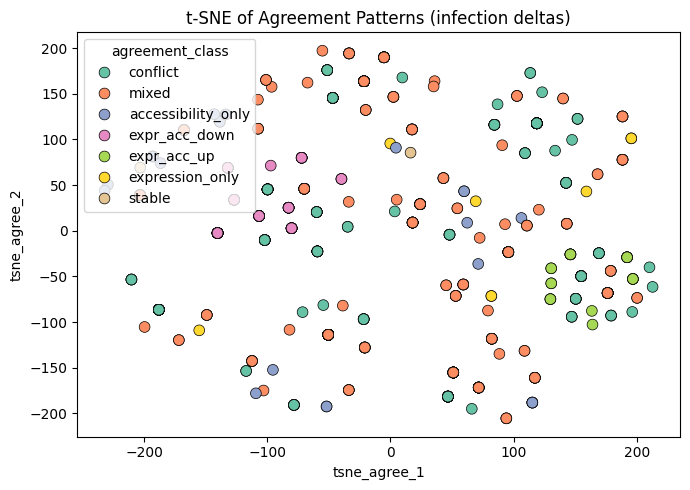

In [12]:
# Expression t-SNE (raw infection deltas)
X = data[expr_cols].fillna(0).values
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)
data['tsne_expr_1'] = X_embedded[:, 0]
data['tsne_expr_2'] = X_embedded[:, 1]

# Agreement t-SNE
agreement_map = {
    'increase': 2,
    'decrease': -2,
    'neutral': 0,
    'expr_only_up': 1,
    'expr_only_down': -1,
    'acc_only_up': 1,
    'acc_only_down': -1,
    'expr_up_acc_down': -2,
    'expr_down_acc_up': 2,
    'NA': np.nan
}
agreement_encoded = data['expr_acc_tss_agreement'].apply(
    lambda seq: [agreement_map.get(s, np.nan) for s in seq]
).apply(pd.Series)
agreement_encoded.columns = ['agree_t1', 'agree_t2', 'agree_t3']
agreement_clean = agreement_encoded.dropna()
meta = data.loc[agreement_clean.index, ['gene_name', 'agreement_class']]
embedding = tsne.fit_transform(agreement_clean.values)
meta['tsne_agree_1'] = embedding[:, 0]
meta['tsne_agree_2'] = embedding[:, 1]

# # Add jitter to reduce overplotting
meta['tsne_1_jitter'] = meta['tsne_agree_1'] + np.random.normal(0, 5.0, size=meta.shape[0])
meta['tsne_2_jitter'] = meta['tsne_agree_2'] + np.random.normal(0, 5.0, size=meta.shape[0])


# Agreement pattern t-SNE plot
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=meta,
    x='tsne_agree_1',
    y='tsne_agree_2',
    hue='agreement_class',
    palette='Set2',
    s=60,
    edgecolor='black',
    linewidth=0.5
)
plt.title("t-SNE of Agreement Patterns (infection deltas)")
plt.tight_layout()
plt.show()

In [19]:
# Save updated CSV
# data.to_csv('data/green_monkey/all_structure_files/chr1/chr1_feature_agreement_summary.csv', index=False)